In [136]:
import numpy as np

import os

import natsort

import matplotlib.pyplot as plt

import cv2


from scipy.ndimage.filters import gaussian_filter1d
from scipy.optimize import leastsq
import matplotlib
from scipy import odr
from scipy import interpolate as spinter
from scipy.ndimage import gaussian_filter

import torch
import skimage.exposure

# import rpy2 for R functions, to use loess in R
import rpy2.robjects as ro
from rpy2.robjects import r
import rpy2.robjects.numpy2ri

# to use R for loess fitting from Python
rpy2.robjects.numpy2ri.activate()

/tmp/ipykernel_1630454/579840732.py:12: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


In [2]:
def generate_synomaly_noise(x, synth_anomaly_masks, mode, anomaly_sigma=7, anomaly_threshold=150, anomaly_offset=0.5, anomaly_direction=1):
    
    noise = torch.zeros(x.shape)
    height, width = x.shape[2:4]

    for i in range(x.shape[0]):
        # create Gaussian background noise
        background_noise = np.random.randn(height, width)

        if mode == "inference":  # do not add synthetic anomalies in inference
            noise[i, 0] = torch.from_numpy(background_noise)

        else:
            # create a mask for shapes
            blur = cv2.GaussianBlur(background_noise, (0, 0), sigmaX=anomaly_sigma, sigmaY=anomaly_sigma, borderType=cv2.BORDER_DEFAULT)
            stretch = skimage.exposure.rescale_intensity(blur, in_range='image', out_range=(0, 255))
            shape_mask = cv2.threshold(stretch, anomaly_threshold, 1, cv2.THRESH_BINARY)[1]

            # crop the mask only to relevant area
            if synth_anomaly_masks is not None:
                synth_anomaly_mask = synth_anomaly_masks[i, 0].cpu().numpy()   # -1 regions not add synthetic anomaly, 1 regions add synthetic anomaly
                shape_mask[synth_anomaly_mask == -1] = 0

            # combine background noise and shape noise
            combined = background_noise.copy()

            combined[shape_mask == 1] += anomaly_direction * (torch.rand(1).item() + anomaly_offset)  # add or reduce 0.0-1.0 plus offset

            noise[i, 0] = torch.from_numpy(combined)

    return noise.to(x.device), shape_mask

In [3]:
def normalize_image(image, low, high):
    """
    Normalize the input image to the range [low, high].

    :param image: Input image as a NumPy array.
    :param low: The lower bound of the target range.
    :param high: The upper bound of the target range.

    :return: The normalized image as a NumPy array.
    """
    # Find the minimum and maximum pixel values in the image
    min_val = np.min(image)
    max_val = np.max(image)

    # Normalize the image to the range [low, high]
    normalized_image = (image - min_val) / (max_val - min_val) * (high - low) + low

    # Convert the image to the appropriate data type (uint8 for an image)
    normalized_image = normalized_image

    return normalized_image

-3.943882 5.4568095


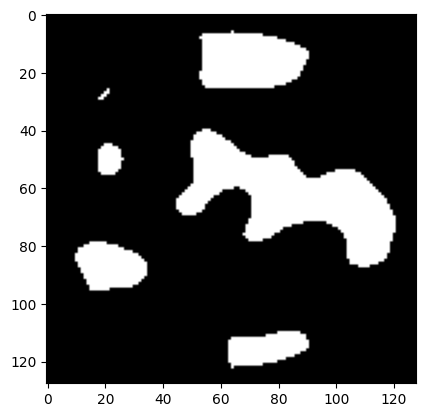

In [58]:
width = 128

x = torch.randn([1,1,width,width])


mode = 'training'
anomaly_sigma = 7
anomaly_threshold = 150
anomaly_offset = 1
anomaly_direction = 1

center_y, center_x = width // 2, width // 2

Y, X = np.ogrid[:width, :width]

dist_from_center = (X - center_x) ** 2 + (Y - center_y) ** 2

radius = width // 2.2

single_vessel_mask = (dist_from_center <= radius ** 2).astype(int)*2-1

synth_anomaly_masks = torch.from_numpy(single_vessel_mask).view(1,1,width,width)

# synth_anomaly_masks = None

noise, shape_mask = generate_synomaly_noise(x, synth_anomaly_masks, mode, anomaly_sigma, anomaly_threshold, anomaly_offset, anomaly_direction)

noise = noise.cpu().detach().numpy().squeeze()
print(noise.min(),noise.max())
noise = normalize_image(noise, 0, 255)
plt.imshow(shape_mask,cmap='gray')

In [5]:
def extract_contours(image):
    """
    Extract contours from a binary image.

    Parameters:
        image (numpy.ndarray): Binary image of the shapes, where the shapes are white (255) and the background is black (0).

    Returns:
        list: List of contours found in the image.
    """
    # Ensure the image is binary
    if len(image.shape) != 2 or image.max() > 1:
        _, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    return contours

In [6]:
def cart2polar(cnt, center):
    """
    Convert cartesian coordinates to polar coordinates with respect to the
    specified center.
    Input: cnt, [[[x1, y1], [x2, y2], ...]]] contour points
           center, center with respect to which the polar coordinates
           were computed

    Output: phi, angles of the polar coordinates
            rho, radius of the polar coordinates with respect to the center
    """

    # get the abscissas and ordinates of the contour
    xcon = cnt[:, 0][:, 0]
    ycon = cnt[:, 0][:, 1]

    # translate to the center
    xs = xcon - center[0]
    ys = ycon - center[1]

    # radius of the translated points from the center
    rho = np.sqrt(xs**2 + ys**2)

    # angle of the translated points
    phi = np.arctan2(ys, xs)

    # numpy atan2 returns from -pi to pi
    # if phi < 0:
    #     phi = phi + 2 * np.pi
    # else:
    #     phi
    phi[phi < 0] = phi[phi < 0] + 2 * np.pi
    # with open("cnt.csv", 'w') as f:
    #     print("x,", "y", file=f)
    #     for x, y in zip(phi, rho):
    #         print(x, ",", y, file=f)

    return phi, rho

In [7]:
def polar2cart(phi, rho, center):
    """
    Convert from polar coordinates to cartesian coordinates. The coordinates
    of the center of rotation is from the origin of the cartesian systems.

    Input: phi, numpy array of angles of the polar coordinates, in radians
           rho, numpy array of the radii with respect to center of rotation
           center, center of rotation in the cartesian coordinate system

    Ouput: xs, numpy array of abscissas
           ys, numpy array of ordinates
    """
    # center of rotation
    cX, cY = center

    # conversion from polar to cartesian
    xs = np.cos(phi) * rho + cX
    ys = np.sin(phi) * rho + cY

    return xs, ys

In [8]:
def rloess_smooth(xdata, ydata, xfit, span=0.07, deg=2):
    """
    Use rpy2 to call R's loess function from Pthon

    Input: x, y numpy array of data points
           xfit, numpy array of data at which yfit it to be computed
           lspan, span of the fitting
           ldeg, deg of the polynomial used for fitting

    Output: x, yfit numpy array of x and smoothed y
    """
    # x = ro.FloatVector(list(xdata))
    # y = ro.FloatVector(list(ydata))
    # x_fit = ro.FloatVector(list(xfit))
    rdf = ro.DataFrame({"x": xdata, "y": ydata})
    loess_fit = r.loess('y ~ x', data=rdf, span=span, deg=deg)
    yfit = np.array(list(r.predict(loess_fit, xfit)))
    return yfit

In [22]:
def particle_countour_params(cnt):
    """
    Derive various partice shape parameters from the boundary trace of the
    particle. Units: pixels

    Input: cnt, the outer most contour (boundary trace) of the particle.

    Output: Dictionary with
            Center of mass, (cX, cY)
            Area, area
            Perimeter, perimeter
            Minimum enclosing circle center and radius, minEnclosingCircle,
            ((mecX, mecY), mecrad)
            Aspect ratio, aspect_ratio
            Diameter: diameter
            Major and min axis of the fitted ellipse: MajMinAxis, (MA, ma)
                (center (x,y), (MA, ma), angle of rotation)
            Minimum area bounding rectangle, minAeaRect,
                (center (x,y), (width, height), angle of rotation)
            Solidity, solidity
    """
    # ref: http://docs.opencv.org/trunk/dd/d49/
    # tutorial_py_contour_features.html

    # find the center of mass from the moments of the contour
    M = cv2.moments(cnt)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])

    # aspect ratio
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = float(w)/h

    # solidity
    area = cv2.contourArea(cnt)
    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    solidity = float(area)/hull_area

    # Equivalent Diameter is the diameter of the circle whose area
    # is same as the contour area
    equi_diameter = np.sqrt(4.0 * area/np.pi)

    # min enclosing circle
    perimeter = cv2.arcLength(cnt, True)
    mec = cv2.minEnclosingCircle(cnt)
    # (mecX, mecY), mecrad

    # minimum area bounding rectangle
    rect = cv2.minAreaRect(cnt)

    # fitting an ellipse
    el = cv2.fitEllipse(cnt)

    return {'center_of_mass': (cX, cY), 'area': area, 'perimeter': perimeter,
            'minEnclosingCircle': mec, 'aspect_ratio': aspect_ratio,
            'diameter': equi_diameter, 'ellipse': el,
            'minAreaRect': rect, 'solidity': solidity}

In [71]:
def max_inscribed_circle(img):
    """
    Determine the largest inscribed circle.

    Input: img, binary image

    Output: (idx_col, idx_row), inscribed_radius, the center of the maximum
            inscribed circle and its radius
    """

    # Calculates the distance to the closest zero pixel for each pixel,
    # the particle is white which is the non-zero (255), the background is
    # black black pixel have zero value. So distance transform is computing
    # the shorted distance of each pixel inside the particle to boundary of
    # the particle. DIST_L2 is Euclidean distance
    edt = cv2.distanceTransform(img, distanceType=cv2.DIST_L2,
                                maskSize=cv2.DIST_MASK_PRECISE)

    # the maximum pixel value, the farthest pixel value is the radius
    inscribed_radius = np.max(edt)

    # to determine the center, get the position of the max value, farthest
    # pixel, the way argmax works, it is necessary to unravel the index to
    # convert from 1D indexing to 2D indexing. The row and column indices
    # returned depends on the unravelling method. The default is (row, col),
    # therefore the center is (col, row)
    idx_max = np.argmax(edt)
    idx_row, idx_col = np.unravel_index(idx_max, img.shape)

    # save the figure
    fig, ax = plt.subplots()
    incircle = plt.Circle((idx_col, idx_row), inscribed_radius, fill=False)
    # cax = ax.imshow(edt, cmap=matplotlib.cm.gray)
    cax = ax.imshow(edt)
    fig.colorbar(cax)
    ax.plot(idx_col, idx_row, 'kx')
    ax.add_artist(incircle)
#     plt.savefig("../plots/" + filename + "_maxinscir.png")
#     plt.close()
    plt.show()

    return {'maxInscribedCircle': ((idx_col, idx_row), inscribed_radius)}

In [29]:
def calc_sphericity(params):
    """
    Compute different sphericity values
    Input: params, dictionary with different shape parameters computed from
           from the smoothed contour

    Output: different sphericity values
    """
    # 2d project area of the particle
    area_2d = params['area']

    # area of the minimum subscribing circle
    rad_mec = params['minEnclosingCircle'][1]
    area_mec = np.pi * rad_mec**2

    # area sphericity
    sa = area_2d/area_mec

    # diameter of the circle having the same area as the projected area
    dia_2d = np.sqrt(4.0/np.pi * area_2d)

    # diameter sphericity
    sd = dia_2d/(2.0 * rad_mec)

    # circle ratio sphericity
    sc = 2 * params['maxInscribedCircle'][1]/(2.0 * rad_mec)

    # perimeter sphericity
    sp = np.pi * dia_2d/params['perimeter']

    # width to length ratio sphericity
    swl = min(params['minAreaRect'][1])/max(params['minAreaRect'][1])

    return {'sa': sa, 'sd': sd, 'sc': sc, 'sp': sp, 'swl': swl}

In [34]:
def lineseg(x, y, tol):
    """
    Form straight line segments from an boundary list.

    Input: x, numpy array of abscissas of the boundary
           y, numpy array of ordinates of the boundary
           tol, maximum deviation from the straight line before a segment
           is broken in two (measured in pixels)

    Output: array of numpy array containing
    """
    # ref: This algorithm is based on Peter Kovesi's
    # http://www.peterkovesi.com/matlabfns/LineSegments/lineseg.m

    # indices of the first and last point of the contour
    fst = 0
    lst = len(x)

    # list to hold the list of segmented points
    seglist = [[x[0], y[0]]]

    while fst < lst:
        # find the size and position of the maximum deviation
        maxdev, idxmaxdev = maxlinedev(x[fst:lst], y[fst:lst])
        # print(maxdev, idxmaxdev)
        # while the maximum deviation from the line > tol shorten the line to
        # the point of maximum deviation by adjusting the last point
        while maxdev > tol:
            lst = fst + idxmaxdev + 1
            # print('lst: ', lst)
            maxdev, idxmaxdev = maxlinedev(x[fst:lst], y[fst:lst])

        # add the last point for which deviation is less than tol to the
        # segemented list
        seglist.append([x[lst-1], y[lst-1]])
        # print('seglist: ', seglist)

        # rest the first and the last point for the next iteration
        fst = lst
        lst = len(x)

    return np.asarray(seglist)

In [35]:
def maxlinedev(x, y):
    """
    Find the point of maximum deviation in the contour from a line joining
    two points on the contour.

    Input: x, numpy array of abscissas of the contour
           y, numpy array of ordinates of the contour

    Output: maxdev, maximum deviation
            idxmaxdev, index of the point of maximum deviation
    """
    # this algorithm is based on:
    # http://www.peterkovesi.com/matlabfns/LineSegments/maxlinedev.m
    # by Peter Kovesi

    # error checking and handling, include later
    if len(x) == 1:
        print("WARNING: Contour contains only one point")

    # Distance between the end points
    x2mx1 = x[-1] - x[0]
    y2my1 = y[-1] - y[0]
    dist = np.sqrt((x2mx1)**2 + (y2my1)**2)

    if dist > np.finfo(float).eps:
        # distance from the line to each point on the contour
        dev = np.abs(x2mx1 * y[0] - y2my1 * x[0] - x2mx1 * y + y2my1 * x)/dist
    else:
        # end points are coincident, calcuate distance from the first point
        dev = calc_dist(x[0], y[0], x, y)

    # maximum deviation and index of maximum deviation
    maxdev = np.max(dev)
    idxmaxdev = np.argmax(dev)

    return maxdev, idxmaxdev

In [37]:
def calc_dist(xc, yc, x, y):
    """
    Compute the distance of each 2D points from the center.

    Arguments:
        xc, yc: The center of the circle
        x, y: The points for distance calculation
    Returns:
        2D Euclidean distance between (xc, yc) and (x, y)
    """
    return np.sqrt((x-xc)**2 + (y-yc)**2)

In [39]:
def convexpoints(seglist, center):
    """
    Not true deterination of convex points. Determine whether a point is
    convex based on the immediate neighbouring points. If the intersection of a
    ray from the specified center with the line joining the immediate
    neighbouring points is closer to the center than the point itself then the
    point is not convex.

    Input: seglist, an array of points [[x1, y1], [x2, y2], ...]
           center, coordinates of the center point

    Ouput: convex, an array of convex points [[x1, y1], [x2, y2], ...]
           concave, an array of concave points [[x1, y1], [x2, y2], ...]
    """

    # center
    cX, cY = center

    # create an empty list hold the coordinate of convex points
    concave = []
    convex = []

    # save the length of the seglist
    seglen = len(seglist)
    # prepend the second last point before the first, this helps to check if
    # the first point is convex or concave, the last and the first points are
    # the same that is why we need to use the second last point.
    seglist = np.insert(seglist, 0, seglist[-2], axis=0)

    # append the second point to the end of the array, which is now the third
    # element after prepending the second last element before the first element
    # seglist = np.append(seglist, [seglist[2]], axis=0)

    # from the first to the second last point check for convex points
    for i in np.arange(0, seglen-1):
        # calculate distance between the center and the middle element
        cdist = np.sqrt((seglist[i+1][0] - cX)**2 + (seglist[i+1][1] - cY)**2)
        linea = linecoef([seglist[i][0], seglist[i][1]],
                         [seglist[i+2][0], seglist[i+2][1]])
        lineb = linecoef([seglist[i+1][0], seglist[i+1][1]], [cX, cY])

        intx, inty = intersection(linea, lineb)

        intdist = np.sqrt((intx - cX)**2 + (inty - cY)**2)

        if intdist:
            if intdist >= cdist:
                concave.append(seglist[i+1])
            else:
                convex.append(seglist[i+1])
        else:
            print('WARNING: No single intersection point detected')

    return np.asarray(convex), np.asarray(concave)

In [41]:
def linecoef(p1, p2):
    """
    Coefficients A, B, C of line equation (Ax + By = C) from
    the two endpoints p1, p2 of the line

    Input: p1, p2 the two points (x, y) of the line segment

    Output: Coefficients of the line equation
    """
    # ref: https://stackoverflow.com/questions/20677795/
    #      how-do-i-compute-the-intersection-point-of-two-lines-in-python

    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0] * p2[1] - p2[0] * p1[1])
    return A, B, -C


def intersection(L1, L2):
    """
    Find the intersection point of the two lines
    A1 * x + B1 * y = C1
    A2 * x + B2 * y = C2
    The intersection point is:
    x = Dx/D
    y = Dy/D
    The determinant D
    A1 B1 which is      L1[0] L1[1]
    A2 B2               L2[0] L2[1]
    Dx:
    C1 B1 which is      L1[2] L1[1]
    C2 B2               L2[2] L2[1]
    and Dy:
    A1 C1 which is      L1[0] L1[2]
    A2 C2               L2[0] L2[2]

    Input: The coefficients returns by linecoef for Line1, Line2
           the two intersecting lines

    Output: x, y the point of intersection
    """

    D = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x, y
    else:
        return False

In [43]:
def corner_circles(convex, cnt, mic, factor, npts, pxltol, tol, maxiter):
    """
    Fit circles to the corners
    Input: convex, array of points[[x1, y1], [x2, y2], ...]
           identified as potential convex corner points
           cnt, [[]]
           cnt, array of points [[x1, y1], [x2, y2], ...]
    """

    # list of circle centers and radius
    cir_centers = []
    cir_radius = []

    # figure out what this range is for
    cir_range = []

    # indices of the first and last point
    fp = 0
    lp = len(convex)

    convex = np.append(convex, [[convex[0, 0], convex[0, 1]]], axis=0)

    # counter to prevent infinite looping, the maximum iteration for n points
    # will not be more than n * (n-1) in this case even if no circles are
    # found. Need to refine this with proper counting theorem but that is for
    # later
    nmax = lp * (lp - 1)
    n = 0
    while lp >= (fp + npts) and n < nmax:
        # print("fp, lp, fp+npts", fp, lp, fp+npts)
        # consider points from starting point (fp) and ending on the
        # last point to fit the circle
        # center_est = (np.mean(convex[fp:lp, 0]), np.mean(convex[fp:lp, 1]))
        center, radius = circle_lstsq(convex[fp:lp, 0], convex[fp:lp, 1])
        # center, radius, residual = gfc.fitcircle(
        #     convex[fp:lp, 0], convex[fp:lp, 1], tol, maxiter)
        # center, radius = circle_3b(convex[fp:lp, 0], convex[fp:lp, 1])
        # compute the radial distance from the new center to all the
        # boundary points of the smoothed contour
        min_dist = cv2.pointPolygonTest(cnt, (center[0], center[1]),
                                        measureDist=True)

        # check if the point lies within the particle,
        # revist this to see if it can be done better by removing the
        # nested if statements
        if min_dist < 0:
            # the point does not lie within the particle
            if lp > (fp + npts):
                # drop the last point and start over again
                lp = lp - 1
            else:
                # no circle found for the given point move to next point
                fp += 1
                lp = len(convex)
        elif min_dist >= 0:
            # the point lines within the particle
            if radius < factor * min_dist or\
             np.abs(radius - min_dist) <= pxltol and radius <= mic:
                # Yeah found a fitting circle
                cir_centers.append([center[0], center[1]])
                cir_radius.append(radius)
                cir_range.append([fp, lp])
                fp = lp + 1
                lp = len(convex)
            elif lp > (fp + npts):
                # if circle not found drop the last point and start over again
                    lp = lp - 1
            else:
                # if circle not found for the given point
                # move to the next point
                fp += 1
                # if no circle found
                lp = len(convex)
                # print('Point inside Here 2')
        n += 1
    return cir_centers, cir_radius, cir_range

In [45]:
def circle_lstsq(x, y):
    xc0 = np.mean(x)
    yc0 = np.mean(y)
    center = (xc0, yc0)
    center_new, ier = leastsq(fc, center, args=(x, y),
                              Dfun=Dfc, col_deriv=True)

    xc_new, yc_new = center_new
    ri = calc_dist(xc_new, yc_new, x, y)
    radius = np.mean(ri)

    return center_new, radius

In [47]:
def fc(center, x, y):
    """ calculate the algebraic distance between the 2D points and
    the mean circle centered at c=(xc, yc) """
    xc, yc = center
    ri = calc_dist(xc, yc, x, y)
    return ri - np.mean(ri)

In [49]:
def Dfc(center, x, y):
    """ Jacobian of fcircle
    The axis corresponding to derivatives
    must be coherent with the col_deriv option of leastsq"""
    xc, yc = center
    dfc = np.empty((2, x.size))

    radius = calc_dist(xc, yc, x, y)
    # df/dxc and df/dyc
    dfc[0] = (xc - x)/radius
    dfc[1] = (yc - y)/radius
    dfc = dfc - dfc.mean(axis=1)[:, np.newaxis]

    return dfc

In [231]:
def smooth_contour(cnt, center, npts, span, sigma, angle):
    """
    Smooth the outline countour generated by openCV using cubic spline
    interpolation. The contour points in cartesian coordinate systems is
    converted to polar coordinate system with center of mass as the center of
    rotation. Smoothing is performed in the polar coordinate system and these
    smoothed polar coordinates are returned. Also save an image of the original
    2D image and the smoothed contour for later reference.

    Input: cnt, array of array of points [[x1, y1], [x2, y2],... [xi,yi]]
           center, center of rotation for convertion from cartesian to
           polar coordinates
           npts, the number of vertices to describe half (180 degrees) the
           curve when converting from cartesian to polar and then smoothing
           span, for loess smoothing
           sigma, for gaussian smoothing
           rotation, rotation angle when the starting point is on the corner
           filename, filename of the 2D image of the particle for saving the
           image with smoothed contour

    Output: phi_sm, the angle in polar coordinate system of the smoothed line
            rho_sm, the radius in polar coordinate system of the smoothed line
            xsm, the smoothed x-coordinates
            ysm, the smoothed y-coordinates
    """
    # create an empty image, openCV is (B, G, R)
    # colors from colorbrewer,
    # http://colorbrewer2.org/#type=diverging&scheme=RdYlBu&n=5
    dark_orange = (253, 174, 97)
    light_yellow = (255, 255, 191)

    # if the starting point is right on one of the corners then it fails to
    # fit a circle at that corner, so the temporary work around right now
    # is to rotate the countours by a small angle and then segment the line
    # and fit the circles
    if angle:
        # extract the x and y coordinates
        x = cnt[:, 0][:, 0]
        y = cnt[:, 0][:, 1]
        cX = center[0]
        cY = center[1]
        xr = (x - cX) * np.cos(angle) + (y - cY) * np.sin(angle) + cX
        yr = -(x - cX) * np.sin(angle) + (y - cY) * np.cos(angle) + cY
        cnt = np.array([[[int(x), int(y)]] for x, y in zip(xr, yr)])

    # change from cartesian coordinate system to polar coordinate system
    # with respect to the centroid, the radii are the two distances to the
    # the edge of the particle from the centroid,
    # num_of_pts are the number of verticles along the contour
    phis, rhos = cart2polar(cnt, center)
    
    

    # sort the arrays to arrange the data in ascending order
    p = phis.argsort()
    phi = phis[p]
    rho = rhos[p]
    rho = gaussian_filter(rho, sigma=5)
    # append part of the array to the end for smooth transition from the
    # last point to the first point, does not seem to help, visit later
    idx_sig = 5 * sigma
    phi = np.append(phi, phi[1:idx_sig] + phi[-1], axis=0)
    rho = np.append(rho, rho[1:idx_sig], axis=0)
    # fig, ax = plt.subplots(1, 1)
    # ax.plot(phi, rho)
    # plt.show()

    # spline interpolation and smoothing
    tck = spinter.splrep(phi, rho, k=3, s=30)
    phi_sm = np.arange(0, 2 * np.pi, np.pi/npts)
    rho_sm = spinter.splev(phi_sm, tck, der=0)

    # loess smoothing, uses R loess if rloess_smooth
#     rho_sm = lowess_ar.lowess(phi, rho, phi_sm, deg=2, l=span)
    rho_sm = rloess_smooth(phi_sm, rho_sm, phi_sm, deg=2, span=span)

    # too many smoothing functions, gaussian filter
    rho_sm = gaussian_filter1d(rho_sm, sigma)

    # smoothed contour in cartesian coordinates for plotting
    xsm, ysm = polar2cart(phi_sm, rho_sm, center)

    # close the contour
    xsm[-1] = xsm[0]
    ysm[-1] = ysm[0]

#     # create array of points contour boundary, for drawing in openCV
#     cnt_sm = np.array([[int(x), int(y)] for x, y in zip(xsm, ysm)])

#     # create a blank image with white background, draw the image of
#     # of the smoothed particle and draw the original particle shape too
#     img = create_blank(640, 480, rgb_color=(255, 255, 255))
#     img = cv2.drawContours(img, [cnt_sm], 0, light_yellow, 2)
#     img = cv2.drawContours(img, [cnt], 0, dark_orange, 2)
#     cv2.imwrite('../plots/' + filename + 'sm_cnt.png', img)

    # return the array of smoothed contour
    return phi_sm, rho_sm, xsm, ysm, phi, rho

In [232]:
# scale of the image, if 247 pixels = 1 mm
# scale = 1/247 mm/pixel
scale = 1.0

# Tolerance and maximum iteration for the Gauss-Newton method
TOL = 1e-5
MAXITER = 1000

# maxium deviation during line segmenting
MAXDEV = 0.2

# Tolerance for radius of the fitted circle
RADTOL = 1.02

# Tolerance for radius of the fitted circle in terms of pixel
PXLTOL = 2

# Minimum number of points for circle fitting
circle_minpts = 3

# number of points describing the contour in the spline smoothing
spline_npts = 2048

# span in loess
loess_span = 0.07

# rotation in radians
# rot = np.pi/180 * 3
rot = 0

# sigma used in gaussian smoothing, 12?
gauss_sigma = 5

params = {}


if shape_mask.max()<=1:
    shape_mask = (shape_mask*255).astype(np.uint8)
size_threshold = 10
# Extract contours
contours = extract_contours(shape_mask)
contours = [contour for contour in contours if cv2.contourArea(contour) >= size_threshold]

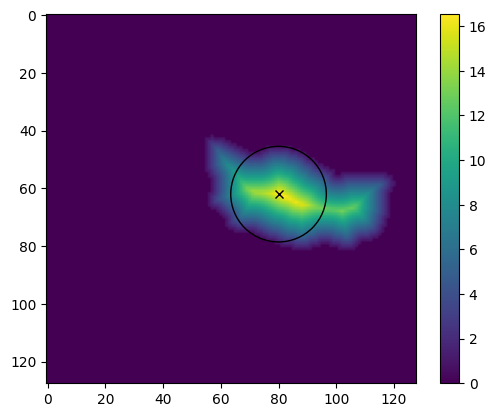

0.4991606959517985


In [233]:
# for cnt in contours:
cnt = contours[3]
# find the center of mass from the moments of the contour
M = cv2.moments(cnt)
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])

# smoothed points in polar and cartesian system
phi_sm, rho_sm, xsm, ysm, phi, rho = smooth_contour(
    cnt, (cX, cY), spline_npts, loess_span,
    gauss_sigma, rot)

# create a blank binary image
img_sm = np.zeros((128, 128), dtype=np.uint8)
# list of array of [x, y] points for the smoothed contour
cnt_sm = np.array([[int(x), int(y)] for x, y in zip(xsm, ysm)])
# update particle parameters from the outer smoothed contour
params.update(particle_countour_params(cnt_sm))

# take the smoothed contour and then create the smoothed particle
# in white
img_sm = cv2.fillPoly(img_sm, [cnt_sm], 225)

# update the parameters with the center and radius of the maximum
# inscribed circle (center(x, y), radius)
params.update(max_inscribed_circle(img_sm))

# update the param with sphericity values
params.update(calc_sphericity(params))

# straight line segments of specified deviation fitted to list of
# boundary points
seglist = lineseg(xsm, ysm, MAXDEV)

# list of convex points
# a convex point is defined as the point which is closer to the
# centroid than the intersection point of:
# (a) line draw with the point's neighbours as the end points
# (b) a ray drawn from the centroid in the direction of the point
pconvex, pconcave = convexpoints(seglist, params['center_of_mass'])

# mic is the maximum inscribed circle radius
mic = params['maxInscribedCircle'][1]
cc, cr, crg = corner_circles(pconvex, cnt_sm, mic, RADTOL,
                             circle_minpts, PXLTOL, TOL, MAXITER)

# compute Wadell's roundness as the ratio of the average radius of the
# fitted circles and the radius of the largest inscribed circle
roundness = np.mean(cr)/mic
print(roundness)

In [152]:
phi_sm.max()

6.2816513263917

In [153]:
rho_sm

array([nan, nan, nan, ..., nan, nan, nan])

In [157]:
rho_sm = gaussian_filter(rho, sigma=3)

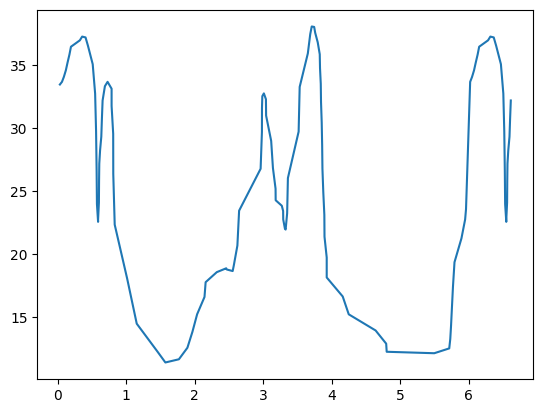

In [211]:
plt.plot(phi, rho)

In [ ]:
phi

In [225]:
# Fit a 2nd-degree polynomial
degree = 20
coefficients = np.polyfit(phi, rho, degree)

# Evaluate the polynomial at finer points
phi_fine = np.linspace(0, 2*np.pi, 500)
rho_fine = np.polyval(coefficients, phi_fine)

/tmp/ipykernel_1630454/780174198.py:3: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(phi, rho, degree)


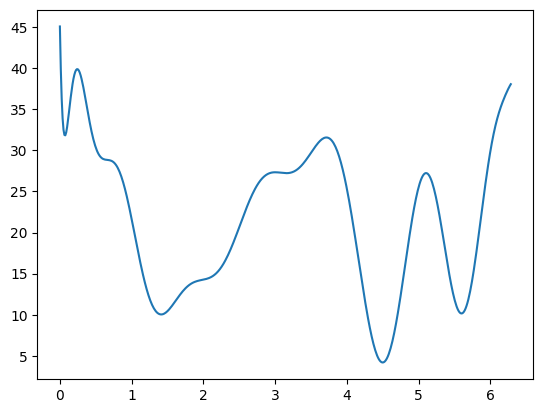

In [226]:
plt.plot(phi_fine, rho_fine)

In [227]:
print(phi)
print(rho)

[0.03029376 0.06053202 0.08800737 0.11710874 0.14189705 0.16977827
 0.19204802 0.32175055 0.35563588 0.40489179 0.43984258 0.50959226
 0.54486392 0.55859932 0.56672922 0.57133748 0.5880026  0.5880026
 0.60005021 0.60228735 0.60554466 0.61719139 0.63502674 0.64350111
 0.65408272 0.68767126 0.72664234 0.78539816 0.78539816 0.80864979
 0.80978357 0.83082144 1.01219701 1.152572   1.46013911 1.57079633
 1.76819189 1.89254688 1.96558745 2.03444394 2.14213381 2.15879893
 2.32172539 2.4592761  2.46685171 2.55359005 2.57025517 2.62244654
 2.64765128 2.96173915 2.98082991 2.98167953 2.98659591 3.00904112
 3.03938594 3.041924   3.11595725 3.14159265 3.18003524 3.18157134
 3.27129519 3.2904826  3.29196408 3.31626485 3.3269406  3.34908888
 3.3602616  3.51686348 3.5321997  3.65118492 3.68645657 3.70832187
 3.74388    3.75878405 3.79567538 3.82530197 3.82926391 3.84025248
 3.84384959 3.85395025 3.86042265 3.86457201 3.87703242 3.89252172
 3.89474393 3.92699082 3.92699082 4.160734   4.24874137 4.64108

In [187]:
tck = spinter.splrep(phi, rho, k=3, s=20)
phi_sm = np.arange(0, 2 * np.pi, np.pi/128)
rho_sm = spinter.splev(phi_sm, tck, der=0)

rho_sm

array([ 32.87548825,  33.20586401,  33.58511693,  34.00051765,
        34.43933684,  34.88884514,  35.33631323,  35.76901174,
        36.17421135,  36.5391827 ,  36.85119646,  37.09752327,
        37.26543381,  37.34219872,  37.31948   ,  37.21337612,
        37.04843594,  36.84921645,  36.64025171,  36.38822017,
        35.87705619,  34.85470091,  33.06909549,  27.34862499,
        22.71756545,  27.55934294,  30.45805828,  32.12940441,
        33.08580356,  33.64942637,  34.12449895,  34.13726885,
        32.41907282,  27.76023868,  21.53066751,  17.21729024,
        14.88327319,  14.09507095,  14.41913808,  15.42192917,
        16.66989879,  17.72950153,  18.21023712,  18.08475552,
        17.50792451,  16.63598118,  15.62516266,  14.63170425,
        13.78005346,  13.08185841,  12.52375839,  12.09239271,
        11.77440065,  11.55642151,  11.42509458,  11.36705916,
        11.36895453,  11.41742   ,  11.49909486,  11.60061839,
        11.7086299 ,  11.80976868,  11.89067403,  11.93

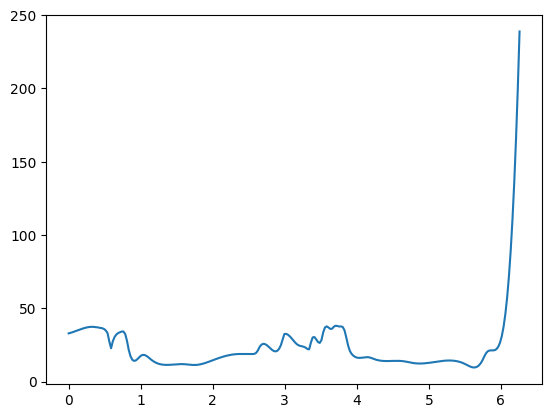

In [188]:
plt.plot(phi_sm, rho_sm)

In [166]:
tck

(array([0.03029376, 0.03029376, 0.03029376, 0.03029376, 0.08800737,
        0.11710874, 0.14189705, 0.16977827, 0.19204802, 0.32175055,
        0.35563588, 0.40489179, 0.43984258, 0.50959226, 0.54486392,
        0.55859932, 0.56672922, 0.57133748, 0.5880026 , 0.5880026 ,
        0.60005021, 0.60228735, 0.60554466, 0.61719139, 0.63502674,
        0.64350111, 0.65408272, 0.68767126, 0.72664234, 0.78539816,
        0.78539816, 0.80864979, 0.80978357, 0.83082144, 1.01219701,
        1.152572  , 1.46013911, 1.57079633, 1.76819189, 1.89254688,
        1.96558745, 2.03444394, 2.14213381, 2.15879893, 2.32172539,
        2.4592761 , 2.46685171, 2.55359005, 2.57025517, 2.62244654,
        2.64765128, 2.96173915, 2.98082991, 2.98167953, 2.98659591,
        3.00904112, 3.03938594, 3.041924  , 3.11595725, 3.14159265,
        3.18003524, 3.18157134, 3.27129519, 3.2904826 , 3.29196408,
        3.31626485, 3.3269406 , 3.34908888, 3.3602616 , 3.51686348,
        3.5321997 , 3.65118492, 3.68645657, 3.70

In [121]:
xcon = cnt[:, 0][:, 0]
ycon = cnt[:, 0][:, 1]

In [126]:
print(np.sqrt((xcon-84)**2+(ycon-63)**2))

[37.80211634 38.01315562 38.83297568 39.11521443 38.58756276 38.94868419
 36.76955262 35.4682957  33.37663854 39.01281841 39.20459157 37.48332963
 33.54101966 32.38826948 31.40063694 30.2654919  30.14962686 26.01922366
 25.01999201 23.19482701 20.22374842 19.41648784 18.43908891 17.2626765
 16.2788206  13.         14.76482306 16.1245155  16.64331698 18.02775638
 19.20937271 20.61552813 20.51828453 18.02775638 16.64331698 15.65247584
 13.         12.64911064 10.19803903 10.          9.05538514  9.8488578
  9.43398113 14.4222051  15.8113883  16.64331698 18.02775638 18.86796226
 23.02172887 23.60084744 25.         29.         30.41381265 31.144823
 32.52691193 33.9411255  36.12478374 36.23534186 37.80211634 38.01315562
 38.83297568 39.11521443 38.58756276 38.94868419 37.57658846 38.07886553
 37.33630941 37.94733192 36.67424164 35.51056181 35.35533906 34.23448554
 34.13209633 33.06055051 33.01514804 25.29822128 24.35159132 23.76972865
 18.35755975 17.         15.26433752 13.89244399 13.038

In [125]:
print(ycon-63)

[-23 -22 -22 -21 -20 -19 -14 -13  -5   1   4   6   6   5   5   4   3  -1
  -1  -3  -3  -4  -4  -3  -3   0   7   8   9  10  12  13  15  15  14  14
  12  12  10  10   9   9   8   8   9   9  10  10  13  14  15  21  22  23
  23  24  24  23  23  22  22  21  20  19  16  15  13  12   7   6   5   4
   3   2   1  -8  -8  -9  -9  -8  -8  -7  -7  -6  -6 -11 -12 -14 -14 -13
 -13 -14 -14 -15 -15 -19 -19 -21 -21 -22 -22 -23]


In [ ]:
def cart2polar(cnt, center):
    """
    Convert cartesian coordinates to polar coordinates with respect to the
    specified center.
    Input: cnt, [[[x1, y1], [x2, y2], ...]]] contour points
           center, center with respect to which the polar coordinates
           were computed

    Output: phi, angles of the polar coordinates
            rho, radius of the polar coordinates with respect to the center
    """

    # get the abscissas and ordinates of the contour
    xcon = cnt[:, 0][:, 0]
    ycon = cnt[:, 0][:, 1]

    # translate to the center
    xs = xcon - center[0]
    ys = ycon - center[1]

    # radius of the translated points from the center
    rho = np.sqrt(xs**2 + ys**2)

    # angle of the translated points
    phi = np.arctan2(ys, xs)

    # numpy atan2 returns from -pi to pi
    # if phi < 0:
    #     phi = phi + 2 * np.pi
    # else:
    #     phi
    phi[phi < 0] = phi[phi < 0] + 2 * np.pi
    # with open("cnt.csv", 'w') as f:
    #     print("x,", "y", file=f)
    #     for x, y in zip(phi, rho):
    #         print(x, ",", y, file=f)

    return phi, rho